In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Load Data

In [2]:
train = pd.read_csv("twitter_train.csv")
# test = pd.read_csv("twitter_test.csv") # no label, so split train into train and valid set
# print(train.shape) # 31962 x 3
train.head() # label: 1 = racist/sexist; 0 = not racist/sexist

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
# sample tweets from both labels
np.random.seed(22)
idx0 = np.where(train['label'] == 0)
idx1 = np.where(train['label'] == 1)
train['tweet'][np.random.choice(idx0[0],10)]
train['tweet'][np.random.choice(idx1[0],10)]

14082    are you #black &amp; feel like the  are â¦on ...
24026    @user after 8 yrs of endless lies, contempt fr...
22285    thought factory: left-right polarisation! #tru...
10852    @user #allahsoil not all muslims hate america....
14530    trump is a cuck  @user #nazi #swastika #ebay! ...
16054    @user comment on @user reveals once more the d...
13425    sign that i checked a bag at iah. every. singl...
19095    @user i hate you with all of my being. #corrup...
16656    it's time to end  now. "days of our lives (liv...
9685     b4 sm we didnt hear this latent  every single ...
Name: tweet, dtype: object

### Format Data

In [4]:
# vec=TfidfVectorizer(stop_words="english")
vec=CountVectorizer(stop_words="english")
vectors = vec.fit_transform(train["tweet"]) # create tf idf from full train data
idx_to_word = np.array(vec.get_feature_names())

##### y to onehot

In [5]:
def list_to_onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y
def onehot_to_list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [6]:
# X = train['tweet'] # word form (31962 tweets,)
X = np.asarray(vectors.todense()) # freq form (31962 tweets, 41104 word frequencies) 
y = train['label']
y_oh = list_to_onehot(y,[0, 1])
# y_test_oh = list_to_onehot(y_test,[0, 1])

##### Split Train Test

In [7]:
X_train =[]
X_test = []
y_test = []
y_train = []
for i in np.arange(X.shape[0]):
    # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
    U = np.random.rand() # Uniform([0,1]) variable
    if U < 0.8:
        # X_train = np.concatenate(X_train,X[i,:])
        X_train.append(X[i,:])
        y_train.append(y_oh[i,:].copy())
    else:
        # X_test = np.concatenate(X_test,X[i,:])
        X_test.append(X[i,:])
        y_test.append(y_oh[i,:].copy())

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [8]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
# X_train[np.random.randint(len(X_train),size=10)]
# y_train[np.random.randint(len(y_train),size=10)]

(25556, 41104) (6406, 41104)
(25556, 2) (6406, 2)


### Wordcloud for each label in train set

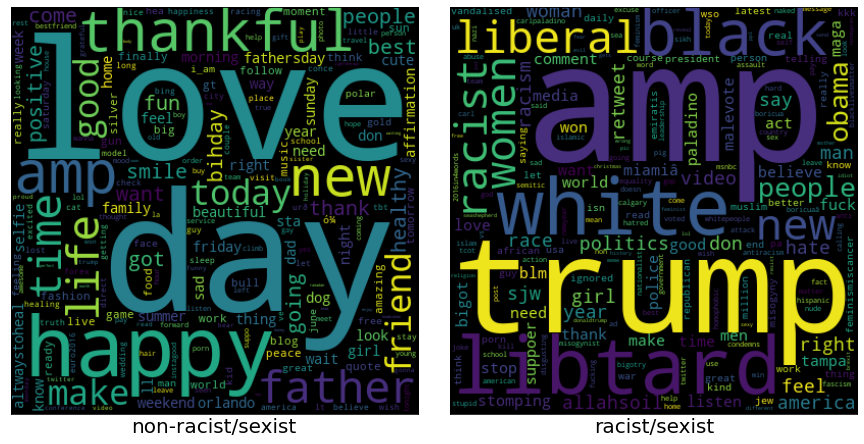

In [9]:
# word cloud for different labels
def plot_wordcloud(Y, H, idx_to_word, categories):
        # plot the class-conditioanl PMF as wordclouds 
        # Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
        # idx_to_word = list of words used in the vectorization of documents 
        # categories = list of class labels
        # prior on class labels = empirical PMF = [ # class i examples / total ]
        # class-conditional for class i = [ # word j in class i examples / # words in class i examples]
        
        class_conditional_PMF = []
        for i in np.arange(Y.shape[1]):
            idx = np.where(Y[:,i]==1)
            sub_H = H[:,idx[0]]
            word_count_per_class = np.sum(sub_H, axis=1)
            class_conditional_PMF.append(word_count_per_class/np.sum(word_count_per_class))
    
        ### topic mode
        num_words_to_sample = 10000
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), subplot_kw={'xticks': [], 'yticks': []})
        for ax, i in zip(axs.flat, np.arange(Y.shape[0])):
            dist = class_conditional_PMF[i]

            # sample (num_words_to_sample) proportionate to CC_PMF
            list_words = []
        
            for j in range(num_words_to_sample):
                idx = np.random.choice(np.arange(H.shape[0]), p=dist)
                list_words.append(idx_to_word[idx])
                
            Y = " ".join(list_words) # list to string
#             print(Y)
            stopwords = STOPWORDS
            stopwords.update(["’", "“", "”", "000", "000 000", "https", "co", "user"])
            wordcloud = WordCloud(background_color="black",
                                  relative_scaling=0.1,
                                  width=400,
                                  height=400).generate(Y)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_xlabel(categories[i], fontsize='20')
            # ax.axis("off")

        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        plt.savefig('class_conditional_PMF_wordcloud_twitter.pdf', bbox_inches='tight')

categories = ['non-racist/sexist','racist/sexist']
plot_wordcloud(Y=np.asarray(y_train), H=X_train.T, idx_to_word=idx_to_word, categories=categories)

## Naive Bayes Classifier

In [10]:
X_train.shape

(25556, 41104)

In [11]:
# subset from 23800 tweets (for memory reasons: 
# MemoryError: Unable to allocate 7.28 GiB for an array with shape (23759, 41104) and data type float64)
X_train_sm = []
y_train_sm = []
for i in np.arange(X_train.shape[0]):
    U = np.random.rand() # Uniform([0,1]) variable
    if U < 0.3:
        # X_train = np.concatenate(X_train,X[i,:])
        X_train_sm.append(X[i,:])
        y_train_sm.append(y_oh[i,:].copy())

In [12]:
X_train_sm = np.array(X_train_sm)
y_train_sm = np.array(y_train_sm)
X_train_sm.shape

(7669, 41104)

In [13]:
def fit_NB(Y, H,pseudocount = 10**-5):
    '''
    Fit Multinomial Naive Bayes Calssifier
    Use the Maximum Likelihood prior and class conditional probabilities (in closed forms)
    Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
    prior on class labels = empirical PMF = [ # class i examples / total ]
    class-conditional for class i = [ # word j in class i examples / # words in class i examples]
    Output = prior (k, ), class_conditional_PMF = (k, p)
    '''
    k = Y.shape[1] # number of classes (2)

    prior = np.sum(Y, axis=0)/np.sum(np.sum(Y, axis=0))
#     print(prior)

    class_conditional_PMF = []
    for i in np.arange(Y.shape[1]):
        idx = np.where(Y[:,i]==1) # select indices with class 0 or 1
        sub_H = H[:,idx[0]] + pseudocount # add psuedocount
        word_count_per_class = np.sum(sub_H, axis=1)
        class_conditional_PMF.append(word_count_per_class/np.sum(word_count_per_class))

    return prior, np.asarray(class_conditional_PMF)

#test 
prior, class_conditional_PMF = fit_NB(Y=y_train_sm, H=X_train_sm.T)
print(prior)
print(class_conditional_PMF)

[0.92723954 0.07276046]
[[2.89591637e-04 2.04772420e-04 1.81701423e-05 ... 1.03600075e-03
  1.81701423e-05 1.20629890e-06]
 [1.09640498e-06 1.97584753e-04 1.09640498e-06 ... 1.09640498e-06
  1.09640498e-06 1.09640498e-06]]


In [14]:
class_conditional_PMF.shape
X_train_sm.shape

(7669, 41104)

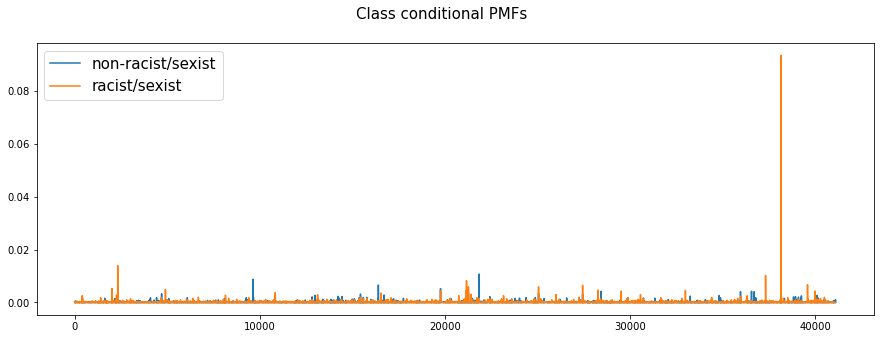

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 5])
for i in [0,1]:
    ax.plot(np.arange(X_train_sm.shape[1]), class_conditional_PMF[i], label=categories[i])
ax.legend(fontsize='15')
plt.suptitle("Class conditional PMFs", fontsize='15')
plt.savefig('class_conditional_PMF_dist_twitter.pdf', bbox_inches='tight')

(6406, 41104)
(2, 41104)


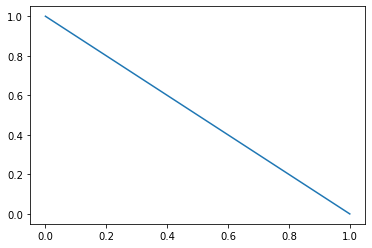

In [16]:
def predict_MNB(X_test, prior, class_conditional_PMF):
    '''
    Compute predicted PMF for the test data given prior and class_conditional_PMF
    Simple use of Bayes' Theorem 
    X_test = (p x n) (words x docs)
    '''
    print(X_test.shape)
    print(class_conditional_PMF.shape)
    
    P = class_conditional_PMF / np.min(class_conditional_PMF) # normalize so that log(P) is not too small 
    Q = np.exp(X_test @ np.log(P).T)
    Q = Q * np.repeat(prior[:, np.newaxis], repeats=Q.shape[0], axis=1).T
    sum_of_rows = Q.sum(axis=1)
    
    return Q / sum_of_rows[:, np.newaxis]

# test 
predictive_PMF = predict_MNB(X_test, prior, class_conditional_PMF)
plt.plot(predictive_PMF[4])

In [17]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix \n ===>', mcm)
            
    return results_dict

In [18]:
y_test
predictive_PMF

array([[9.99988096e-01, 1.19044554e-05],
       [1.00000000e+00, 8.71406186e-15],
       [9.99980538e-01, 1.94622414e-05],
       ...,
       [9.98790652e-01, 1.20934838e-03],
       [1.21780102e-17, 1.00000000e+00],
       [9.96782909e-01, 3.21709092e-03]])

In [38]:
result_dict_list = []
W_list = []
results_dict = compute_accuracy_metrics(Y_test=onehot_to_list(y_test), P_pred=predictive_PMF[:,1], verbose=True)
result_dict_list.append(results_dict.copy())
W_list.append(results_dict.get('Confusion_mx').copy())

# scale W_list by count
print(W_list[0])
true_counts = np.sum(W_list[0],axis=0)
print(true_counts)
W_list2 = []
W_list2.append(W_list[0] / true_counts)
W_list2

AUC ===> 0.947
Opt_threshold ===> 0.000
Accuracy ===> 0.963
Sensitivity ===> 0.989
Specificity ===> 0.625
Precision ===> 0.816
Fall_out ===> 0.011
Miss_rate ===> 0.375
Confusion matrix 
 ===> [[5880   65]
 [ 173  288]]
[[5880   65]
 [ 173  288]]
[6053  353]


[array([[0.97141913, 0.18413598],
        [0.02858087, 0.81586402]])]

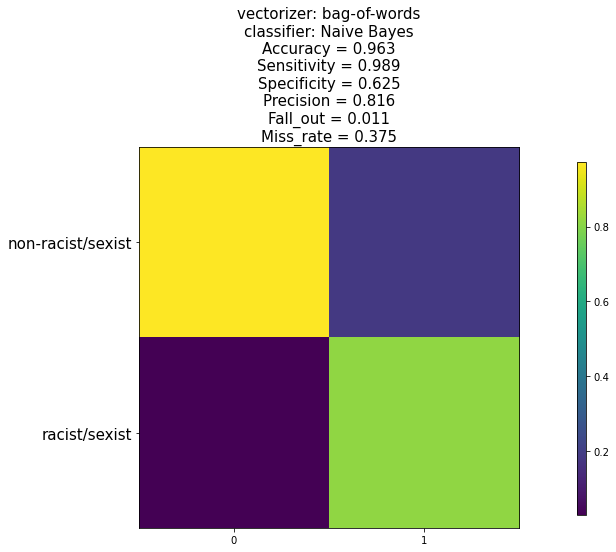

In [44]:
# make plot
list_vectorizer = ['bag-of-words']
fig, ax = plt.subplots(nrows=1, ncols=len(list_vectorizer), figsize=[12, 7])
class_labels= categories
for i in np.arange(len(list_vectorizer)):
    results_dict = result_dict_list[i]
    confusion_mx = results_dict.get('Confusion_mx')
    if len(list_vectorizer) > 1:
        confusion_mx = W_list2[i]
        im = ax[i].imshow(confusion_mx, vmin=np.min(W_list2), vmax=np.max(W_list2))
        ax[i].title.set_text("NB Confusion mx using %s vectorizer" % list_vectorizer[i])
        # ax[i].legend()
        # if i == len(list_digits) - 1:
        ax[i].set_xticks(np.arange(len(class_labels)))
        # ax[i].set_xticklabels(class_labels)
        ax[i].set_yticks(np.arange(len(class_labels)))
        ax[i].set_yticklabels(class_labels)
    else:
        confusion_mx = W_list2[i]
        im = ax.imshow(confusion_mx, vmin=np.min(W_list2), vmax=np.max(W_list2))
        ax.title.set_text("NB Confusion mx using %s vectorizer" % list_vectorizer[i])
        # ax[i].legend()
        # if i == len(list_digits) - 1:
        ax.set_xticks(np.arange(len(class_labels)))
        ax.set_yticks(np.arange(len(class_labels)))
        ax.set_yticklabels(class_labels, fontsize='15')
    
    subtitle = "vectorizer: " + str(list_vectorizer[i]) + "\n" + "classifier: " + str('Naive Bayes')
    keys_list = [i for i in results_dict.keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold', 'Confusion_mx']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_dict.get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
    ax.set_title(subtitle, fontsize='15')
    
cbar_ax = fig.add_axes([0.8, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('count_confusion_mat_twitter.pdf', bbox_inches='tight')